# Benchmarks

- **Well-conditioned quadratic functions**
- **Ill-conditioned quadratic function**
- **Rosenbrock function**
- **MNIST Neural Network Training** - `In different file`

## Extra Benchmarks

- **Rastrigin Function**
- **Ackley Function**
- **Himmelblau Function**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Helper: Quadratic function generator
# -------------------------------
def generate_quadratic(dim=10, cond_number=10):
    """Generate symmetric positive definite Q with given condition number."""
    V = np.linalg.qr(np.random.randn(dim, dim))[0]  # orthogonal matrix
    eigvals = np.linspace(1, cond_number, dim)      # spread of eigenvalues
    Q = V @ np.diag(eigvals) @ V.T
    return Q

# Quadratic function and gradient
def quadratic_f(x, Q):
    return 0.5 * x.T @ Q @ x

def quadratic_grad(x, Q):
    return Q @ x

# Rosenbrock function and gradient
def rosenbrock_f(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def rosenbrock_grad(x):
    dx = -2*(1 - x[0]) - 400*x[0]*(x[1] - x[0]**2)
    dy = 200*(x[1] - x[0]**2)
    return np.array([dx, dy])

# -------------------------------
# Optimizers (with loss tracking)
# -------------------------------
def sgd_momentum(f, grad_f, x0, lr=0.01, beta=0.9, tol=1e-6, max_iter=10000):
    x = x0.copy()
    v = np.zeros_like(x)
    losses = []
    for i in range(max_iter):
        loss = f(x); losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        v = beta * v + (1 - beta) * g
        x -= lr * v
    return x, i + 1, losses

def adam(f, grad_f, x0, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, tol=1e-6, max_iter=10000):
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    losses = []
    for t in range(1, max_iter + 1):
        loss = f(x); losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        x -= lr * m_hat / (np.sqrt(v_hat) + eps)
    return x, t, losses

def rmsprop(f, grad_f, x0, lr=0.001, beta=0.9, eps=1e-8, tol=1e-6, max_iter=10000):
    x = x0.copy()
    s = np.zeros_like(x)
    losses = []
    for i in range(max_iter):
        loss = f(x); losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        s = beta * s + (1 - beta) * (g ** 2)
        x -= lr * g / (np.sqrt(s) + eps)
    return x, i + 1, losses

# ---------------------------------------------------------
# DAM Optimizer
# ---------------------------------------------------------
def dam(f, grad_f, x0, lr=0.001, beta1=0.9, beta2=0.999,
        eps=1e-8, scale_bad=0.5, tol=1e-6, max_iter=10000):

    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    prev_diff = np.zeros_like(x) + np.inf
    t = 0
    losses = []

    for i in range(max_iter):
        loss = f(x)
        losses.append(loss)

        g_old = grad_f(x)
        if np.linalg.norm(g_old) < tol:
            break

        t += 1

        # Adam moments
        m = beta1 * m + (1 - beta1) * g_old
        v = beta2 * v + (1 - beta2) * (g_old * g_old)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)

        # tentative update
        x_new = x - lr * m_hat / (np.sqrt(v_hat) + eps)

        # compare gradient directions
        g_new = grad_f(x_new)
        diff_norm = np.linalg.norm(g_new - g_old)

        scale = 1.0 if diff_norm < np.linalg.norm(prev_diff) else scale_bad

        # reinforce/dampen m
        m = beta1 * m + (1 - beta1) * g_old * scale

        prev_diff = g_new - g_old
        x = x_new

    return x, i + 1, losses

# -------------------------------
# Experiment Runner + Plotter
# -------------------------------
def run_and_plot(f, grad_f, x0, optimizers, tol, f_name, logy=True):
    plt.figure(figsize=(7, 5))
    for name, opt in optimizers.items():
        x_opt, n_iter, losses = opt(f, grad_f, x0)
        print(f"{f_name} | {name} converged in {n_iter} iterations.")
        plt.plot(losses, label=name)
    if logy:
        plt.yscale('log')
    plt.xlabel("Iterations")
    plt.ylabel("Loss value")
    plt.title(f"Loss Decay: {f_name}")
    plt.legend()
    plt.grid(True)
    plt.show()

def run_multiple_seeds(f, grad_f, dim_or_x0, optimizers, tol, f_name,
                       n_seeds=5, logy=True):

    results = {name: [] for name in optimizers}

    for seed in range(n_seeds):
        np.random.seed(seed)

        x0 = (np.random.randn(dim_or_x0) if isinstance(dim_or_x0,int)
              else np.array(dim_or_x0, dtype=float))

        print(f"\nSeed {seed}")

        # Run each optimizer
        for name, opt in optimizers.items():
            _, iters, losses = opt(f, grad_f, x0)
            results[name].append(iters)

    # ---- Print mean ± std ----
    print(f"\n===== {f_name}: Mean ± Std over {n_seeds} seeds =====")
    for name in results:
        arr = np.array(results[name])
        print(f"{name}: {arr.mean():.1f} ± {arr.std():.1f} iterations")

    # ---- Plot average loss curves ----
    plt.figure(figsize=(7,5))
    for name, opt in optimizers.items():
        avg_losses = None
        for seed in range(n_seeds):
            np.random.seed(seed)
            x0 = (np.random.randn(dim_or_x0) if isinstance(dim_or_x0,int)
                  else np.array(dim_or_x0, dtype=float))
            _, _, losses = opt(f, grad_f, x0)
            losses = np.array(losses)

            if avg_losses is None:
                avg_losses = losses
            else:
                L = min(len(avg_losses), len(losses))
                avg_losses = avg_losses[:L] + losses[:L]

        avg_losses /= n_seeds
        plt.plot(avg_losses, label=f"{name}")

    if logy: plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title(f"{f_name} (Average Loss over {n_seeds} seeds)")
    plt.legend()
    plt.grid(True)
    plt.show()

    return results


--- Well-Conditioned Quadratic ---

Seed 0

Seed 1

Seed 2

Seed 3

Seed 4

===== Well-Conditioned Quadratic: Mean ± Std over 5 seeds =====
SGD+Momentum: 9856.8 ± 286.4 iterations
Adam: 7051.4 ± 573.9 iterations
RMSProp: 10000.0 ± 0.0 iterations
DAM: 7670.4 ± 629.5 iterations


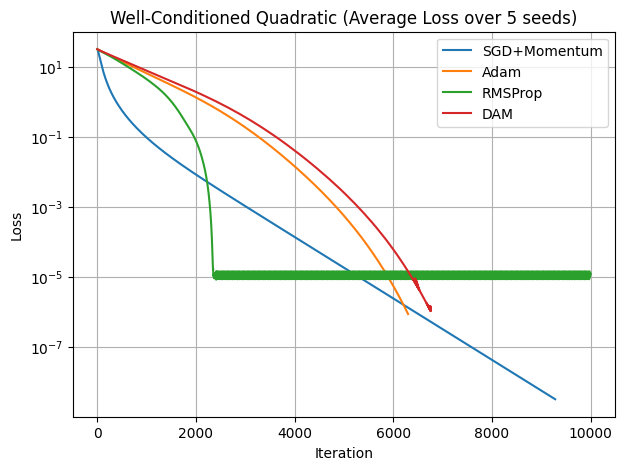

{'SGD+Momentum': [10000, 10000, 10000, 10000, 9284],
 'Adam': [7926, 7429, 6640, 6960, 6302],
 'RMSProp': [10000, 10000, 10000, 10000, 10000],
 'DAM': [8448, 7959, 7114, 8069, 6762]}

In [3]:

# ============================================================
# 1. Well-conditioned Quadratic
# ============================================================
print("\n--- Well-Conditioned Quadratic ---")
dim = 10
Q_well = generate_quadratic(dim, cond_number=10)
x0 = np.random.randn(dim)
optimizers = {
    "SGD+Momentum": lambda f, g, x0=x0: sgd_momentum(f, g, x0, lr=0.001, beta=0.9, tol=1e-6),
    "Adam": lambda f, g, x0=x0: adam(f, g, x0, lr=0.001, beta1=0.9, beta2=0.999, tol=1e-6),
    "RMSProp": lambda f, g, x0=x0: rmsprop(f, g, x0, lr=0.001, beta=0.9, tol=1e-6),
    "DAM": lambda f, g, x0=x0: dam(f, g, x0, lr=0.001, beta1=0.9, beta2=0.999, tol=1e-6)
}
run_multiple_seeds(
    lambda x: quadratic_f(x, Q_well),
    lambda x: quadratic_grad(x, Q_well),
    dim_or_x0=dim,       # works for fixed x0 arrays OR dim-int samplers
    optimizers=optimizers,
    tol=1e-6,
    f_name="Well-Conditioned Quadratic",
    n_seeds=5
)




--- Ill-Conditioned Quadratic ---

Seed 0

Seed 1

Seed 2

Seed 3

Seed 4

===== Ill-Conditioned Quadratic: Mean ± Std over 5 seeds =====
SGD+Momentum: 10000.0 ± 0.0 iterations
Adam: 9781.0 ± 438.0 iterations
RMSProp: 10000.0 ± 0.0 iterations
DAM: 9865.4 ± 269.2 iterations


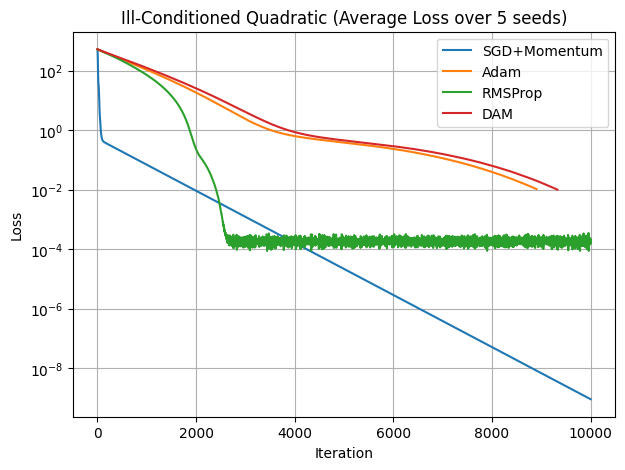

{'SGD+Momentum': [10000, 10000, 10000, 10000, 10000],
 'Adam': [10000, 10000, 10000, 10000, 8905],
 'RMSProp': [10000, 10000, 10000, 10000, 10000],
 'DAM': [10000, 10000, 10000, 10000, 9327]}

In [4]:
# ============================================================
# 2. Ill-conditioned Quadratic
# ============================================================
print("\n--- Ill-Conditioned Quadratic ---")
dim = 10
Q_ill = generate_quadratic(dim, cond_number=200)
x0 = np.random.randn(dim)
optimizers = {
    "SGD+Momentum": lambda f, g, x0=x0: sgd_momentum(f, g, x0, lr=0.001, beta=0.9, tol=1e-6),
    "Adam": lambda f, g, x0=x0: adam(f, g, x0, lr=0.001, beta1=0.9, beta2=0.999, tol=1e-6),
    "RMSProp": lambda f, g, x0=x0: rmsprop(f, g, x0, lr=0.001, beta=0.9, tol=1e-6),
    "DAM": lambda f, g, x0=x0: dam(f, g, x0, lr=0.001, beta1=0.9, beta2=0.999, tol=1e-6)
}
run_multiple_seeds(
    lambda x: quadratic_f(x, Q_ill),
    lambda x: quadratic_grad(x, Q_ill),
    dim_or_x0=dim,               # <-- IMPORTANT: use dim here, not x0
    optimizers=optimizers,
    tol=1e-6,
    f_name="Ill-Conditioned Quadratic",
    n_seeds=5
)



--- Rosenbrock Function ---

Seed 0

Seed 1

Seed 2

Seed 3

Seed 4

===== Rosenbrock Function: Mean ± Std over 5 seeds =====
SGD+Momentum: 31923.0 ± 0.0 iterations
Adam: 12686.0 ± 0.0 iterations
RMSProp: 50000.0 ± 0.0 iterations
DAM: 50000.0 ± 0.0 iterations


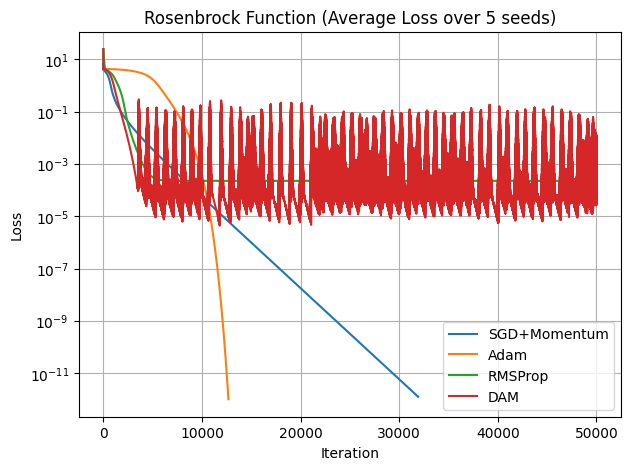

{'SGD+Momentum': [31923, 31923, 31923, 31923, 31923],
 'Adam': [12686, 12686, 12686, 12686, 12686],
 'RMSProp': [50000, 50000, 50000, 50000, 50000],
 'DAM': [50000, 50000, 50000, 50000, 50000]}

In [11]:

# ============================================================
# 3. Rosenbrock
# ============================================================
print("\n--- Rosenbrock Function ---")
x0 = np.array([-1.2, 1.0])
optimizers = {
    "SGD+Momentum": lambda f, g, x0=x0: sgd_momentum(f, g, x0, lr=0.001, beta=0.9, tol=1e-6, max_iter=50000),
    "Adam": lambda f, g, x0=x0: adam(f, g, x0, lr=0.001, beta1=0.9, beta2=0.999, tol=1e-6, max_iter=50000),
    "RMSProp": lambda f, g, x0=x0: rmsprop(f, g, x0, lr=0.001, beta=0.9, tol=1e-6, max_iter=50000),
    "DAM": lambda f, g, x0=x0: dam(f, g, x0, lr=0.01, beta1=0.9, beta2=0.999, tol=1e-6, max_iter=50000)
}
run_multiple_seeds(
    rosenbrock_f,
    rosenbrock_grad,
    dim_or_x0=x0,   # fixed start for all seeds
    optimizers=optimizers,
    tol=1e-4,
    f_name="Rosenbrock Function",
    n_seeds=5
)



# Extra Benchmarks

In [6]:

# ============================================================
# Rastrigin
# ============================================================
def rastrigin_f(x):
    x = np.array(x)
    A = 10
    return A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x))

def rastrigin_grad(x):
    x = np.array(x)
    A = 10
    return 2 * x + A * 2 * np.pi * np.sin(2 * np.pi * x)

# ============================================================
# Ackley
# ============================================================
def ackley_f(x):
    x = np.array(x)
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = len(x)
    term1 = -a * np.exp(-b * np.sqrt(np.sum(x*x) / d))
    term2 = -np.exp(np.sum(np.cos(c * x)) / d)
    return term1 + term2 + a + np.e

def ackley_grad(x):
    x = np.array(x)
    a = 20
    b = 0.2
    c = 2 * np.pi
    d = len(x)

    r = np.sqrt(np.sum(x*x) / d)
    if r == 0:
        r = 1e-12

    grad1 = a * b * (x / (d * r)) * np.exp(-b * r)
    grad2 = c * np.sin(c * x) / d * np.exp(np.sum(np.cos(c*x)) / d)
    return grad1 + grad2

# ============================================================
# Himmelblau
# ============================================================
def himmelblau_f(x):
    x1, x2 = x
    return (x1*x1 + x2 - 11)**2 + (x1 + x2*x2 - 7)**2

def himmelblau_grad(x):
    x1, x2 = x
    df_dx = 4*x1*(x1*x1 + x2 - 11) + 2*(x1 + x2*x2 - 7)
    df_dy = 2*(x1*x1 + x2 - 11) + 4*x2*(x1 + x2*x2 - 7)
    return np.array([df_dx, df_dy])

# ============================================================
# Optimizers
# ============================================================
def sgd_momentum(f, grad_f, x0, lr=0.01, beta=0.9, tol=1e-6, max_iter=5000):
    x = x0.copy()
    v = np.zeros_like(x)
    losses = []
    for i in range(max_iter):
        loss = f(x)
        losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        v = beta*v + (1-beta)*g
        x -= lr * v
    return x, i+1, losses



--- Rastrigin ---

Seed 0

Seed 1

Seed 2

Seed 3

Seed 4

===== Rastrigin: Mean ± Std over 5 seeds =====
SGD+Momentum: 370.4 ± 3.9 iterations
Adam: 1365.2 ± 14.1 iterations
RMSProp: 10000.0 ± 0.0 iterations
DAM: 2961.0 ± 2717.1 iterations


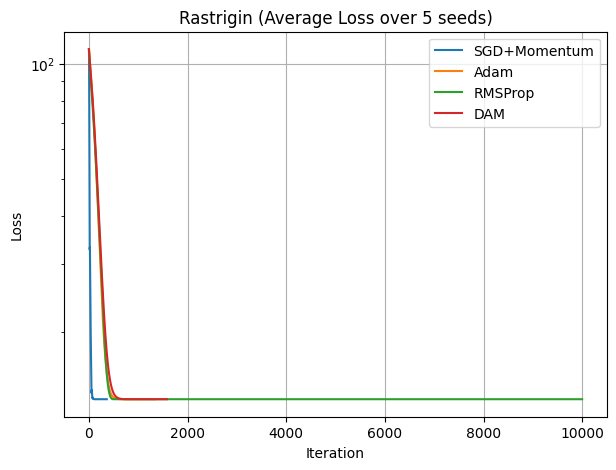

{'SGD+Momentum': [363, 373, 370, 372, 374],
 'Adam': [1379, 1338, 1367, 1371, 1371],
 'RMSProp': [10000, 10000, 10000, 10000, 10000],
 'DAM': [1584, 1584, 1617, 1625, 8395]}

In [7]:

# ============================================================
# 5. Rastrigin
# ============================================================
print("\n--- Rastrigin ---")
optimizers = {
    "SGD+Momentum": lambda f, g, x0: sgd_momentum(f, g, x0, lr=0.001, beta=0.9, tol=1e-6),
    "Adam": lambda f, g, x0: adam(f, g, x0, lr=0.001, beta1=0.9, beta2=0.999, tol=1e-6),
    "RMSProp": lambda f, g, x0: rmsprop(f, g, x0, lr=0.001, beta=0.9, tol=1e-6),
    "DAM": lambda f, g, x0: dam(f, g, x0, lr=0.001, beta1=0.9, beta2=0.999, tol=1e-6)
}
run_multiple_seeds(
    rastrigin_f,
    rastrigin_grad,
    dim_or_x0=10,          # random 10D x0 each seed
    optimizers=optimizers,
    tol=1e-4,
    f_name="Rastrigin",
    n_seeds=5
)


--- Ackley ---

Seed 0

Seed 1

Seed 2

Seed 3

Seed 4

===== Ackley: Mean ± Std over 5 seeds =====
SGD+Momentum: 1844.0 ± 210.5 iterations
Adam: 1141.0 ± 140.1 iterations
RMSProp: 10000.0 ± 0.0 iterations
DAM: 1408.2 ± 163.9 iterations


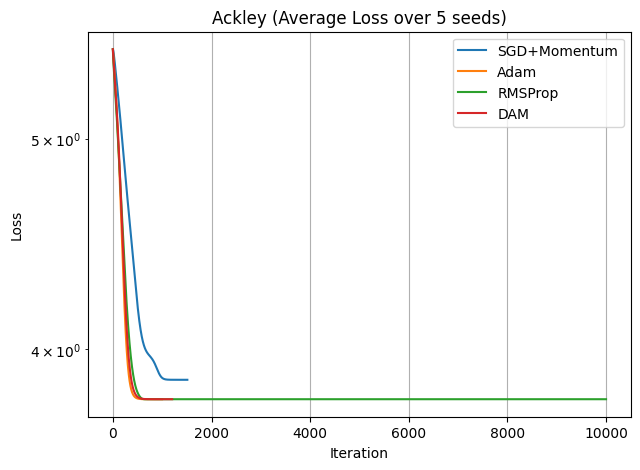

{'SGD+Momentum': [1511, 2148, 1766, 1841, 1954],
 'Adam': [1078, 1208, 1038, 998, 1383],
 'RMSProp': [10000, 10000, 10000, 10000, 10000],
 'DAM': [1550, 1426, 1244, 1202, 1619]}

In [8]:

# ============================================================
# 6. Ackley
# ============================================================
print("\n--- Ackley ---")
optimizers = {
    "SGD+Momentum": lambda f, g, x0: sgd_momentum(f, g, x0, lr=0.001, beta=0.9, tol=1e-6),
    "Adam": lambda f, g, x0: adam(f, g, x0, lr=0.001, beta1=0.9, beta2=0.999, tol=1e-6),
    "RMSProp": lambda f, g, x0: rmsprop(f, g, x0, lr=0.001, beta=0.9, tol=1e-6),
    "DAM": lambda f, g, x0: dam(f, g, x0, lr=0.001, beta1=0.9, beta2=0.999, tol=1e-6)
}
run_multiple_seeds(
    ackley_f,
    ackley_grad,
    dim_or_x0=10,         # random 10D x0 per seed
    optimizers=optimizers,
    tol=1e-4,
    f_name="Ackley",
    n_seeds=5
)


--- Himmelblau ---

Seed 0

Seed 1

Seed 2

Seed 3

Seed 4

===== Himmelblau: Mean ± Std over 5 seeds =====
SGD+Momentum: 346.0 ± 0.0 iterations
Adam: 5025.0 ± 0.0 iterations
RMSProp: 10000.0 ± 0.0 iterations
DAM: 5433.0 ± 0.0 iterations


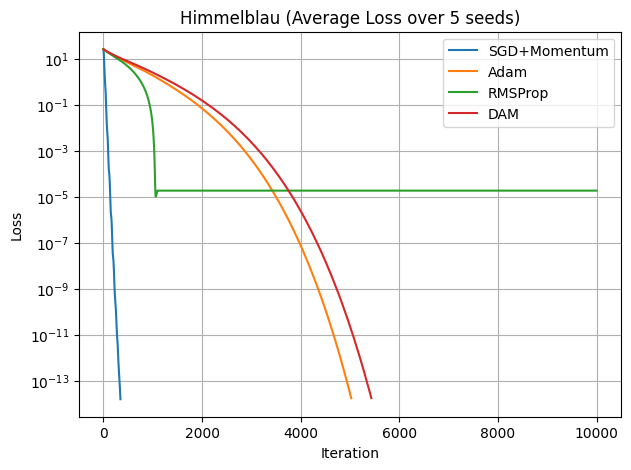

{'SGD+Momentum': [346, 346, 346, 346, 346],
 'Adam': [5025, 5025, 5025, 5025, 5025],
 'RMSProp': [10000, 10000, 10000, 10000, 10000],
 'DAM': [5433, 5433, 5433, 5433, 5433]}

In [9]:

# ============================================================
# 7. Himmelblau
# ============================================================
print("\n--- Himmelblau ---")
x0 = np.array([3.0, 3.0])
optimizers = {
    "SGD+Momentum": lambda f, g, x0=x0: sgd_momentum(f, g, x0, lr=0.001, beta=0.9, tol=1e-6),
    "Adam": lambda f, g, x0=x0: adam(f, g, x0, lr=0.001, beta1=0.9, beta2=0.999, tol=1e-6),
    "RMSProp": lambda f, g, x0=x0: rmsprop(f, g, x0, lr=0.001, beta=0.9, tol=1e-6),
    "DAM": lambda f, g, x0=x0: dam(f, g, x0, lr=0.001, beta1=0.9, beta2=0.999, tol=1e-6)
}
run_multiple_seeds(
    himmelblau_f,
    himmelblau_grad,
    dim_or_x0=x0,         # fixed 2D start for all seeds
    optimizers=optimizers,
    tol=1e-4,
    f_name="Himmelblau",
    n_seeds=5
)

# Benchmark Function Descriptions

## 1. Rastrigin Function
**Type:** Non-convex, multimodal  
**Difficulty:** Many local minima, highly oscillatory  
**Formula:**
f(x) = A·n + Σ [ xᵢ² − A·cos(2πxᵢ) ],  A = 10

**Properties:**
- Very bumpy landscape  
- Many symmetric local minima  
- Global minimum at x = 0  
- Good for testing exploration and escaping shallow minima  

---

## 2. Ackley Function
**Type:** Non-convex, multimodal  
**Difficulty:** Flat region + steep basin  
**Formula:**
f(x) = -a·exp( -b·√( (1/n) Σ xᵢ² ) )  
        - exp( (1/n) Σ cos(c·xᵢ) ) + a + e  
with a = 20, b = 0.2, c = 2π

**Properties:**
- Nearly flat outer region → optimizers stall  
- Rapid drop into a narrow global basin  
- Many cosine-based local minima  
- Standard global optimization benchmark  

---

## 3. Himmelblau Function
**Type:** Non-convex, multiple global minima  
**Difficulty:** Several basins of attraction  
**Formula:**
f(x,y) = (x² + y − 11)² + (x + y² − 7)²

**Properties:**
- Four global minima  
- Several saddle points  
- Good for testing how well optimizers navigate multiple basins  
- Commonly used in visualization studies  

---
